# Réseau de neurone ``PyTorch``- Prédiction de vainqueur sur StarCraft 2

Le dataset représente de nombreuses parties 1 contre 1 sur le jeu StarCraft 2.
Pour chaque replay est enregistré à chaque temps T l'etat du jeu (26 champs) ainsi que le vainqueur (1 champ), indiqué en dernière colonne par 0 ou 1.

<img src="files/figures/sc2_logo.png" width="600px"/>

Nous définirons et entraînerons un réseau de neurones sur ce dataset. C'est un problème de régression car nous voulons une probabilité de victoire.<br>
Nous commencerons par programmer notre réseau de neurones en affichant les données pertinentes, et nous passerons à une étude de cas pour concrétiser l'utilisation du programme.

## 1. Librairies

In [19]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset, random_split

## 2. Exploration des datasets

- L'étape la plus longue pour arriver à entraîner notre IA a consisté en l'élaboration d'un dataset de qualité pour le sujet qui nous intéressait. Nous avons dû écrire un programme permettant de générer un grand nombre de rows (lignes) sur de nombreuses données permettant de décrire l'état d'une partie de StarCraft 2 en cours.<br>
Le code source de ce parseur est disponible sur github :<br>
https://github.com/YannBgit/SC2replayDatasetGenerator

- Ce programme a pu être écrit grâce à l'API sc2reader qui permet d'extraire des données de fichiers SC2Replay. Son code source est également disponible :<br>
https://github.com/ggtracker/sc2reader

- Le parseur contient des fonctionnalités d'ergonomie et de randomisation de datasets. Sans entrer dans les détails (l'utilisation est détaillée dans le README), il est possible à partir d'un répertoire contenant un grand nombre de replays de choisir le nombre à utiliser pour le dataset, qu'un script va sélectionner aléatoirement dans le répertoire source.<br>
- Le parseur va ensuite extraire des données de ces replays pour générer un grand nombre de rows correspondant chacun à un instant dans la partie étudiée.<br><br>
- L'étape suivante a été de trouver un grand nombre de replays exploitables à donner au parseur. Heureusement, Blizzard, le studio produisant le jeu, a rendu public une base de données massive de replays anonymisés qui ont servi aux équipes de Google pour entraîner l'IA AlphaStar. Nous avons donc pu parser 30 000 replays.
- Affichage des données.

In [20]:
data = pd.read_csv("archive/dataset.csv")
data.head(3)

,time,race1,race2,map,supplyUsed1,supplyUsed2,totalIncome1,totalIncome2,mineralsIncome1,mineralsIncome2,...,vespene2,activeWorkers1,activeWorkers2,army1,army2,technology1,technology2,lostResources1,lostResources2,winner
0,7,0,0,0,13.0,13.0,210,150,210,150,...,0,12,12,0,0,0,0,0,0,0
1,14,0,0,0,14.0,14.0,480,480,480,480,...,0,13,13,0,0,0,0,0,0,0
2,21,0,0,0,14.0,14.0,520,500,520,500,...,0,13,13,0,0,0,0,0,0,0


In [21]:
data.dtypes

time                 int64
race1                int64
race2                int64
map                  int64
supplyUsed1        float64
supplyUsed2        float64
totalIncome1         int64
totalIncome2         int64
mineralsIncome1      int64
mineralsIncome2      int64
vespeneIncome1       int64
vespeneIncome2       int64
totalResources1      int64
totalResources2      int64
minerals1            int64
minerals2            int64
vespene1             int64
vespene2             int64
activeWorkers1       int64
activeWorkers2       int64
army1                int64
army2                int64
technology1          int64
technology2          int64
lostResources1       int64
lostResources2       int64
winner               int64
dtype: object

In [22]:
len(data.index)

2178246

In [23]:
len(data.columns)

27

In [24]:
data.race1.value_counts()

1    802067
0    749308
2    626871
Name: race1, dtype: int64

- Visualisation des relations entre les colonnes.

<AxesSubplot:>

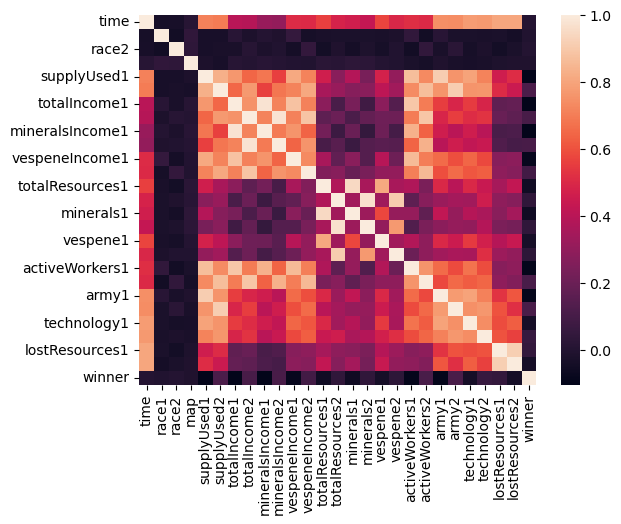

In [25]:
sns.heatmap(data.corr())

- Création des ensembles d'entraînement, d'évaluation et de test. <br>
A noter que le préprocessing a été géré par le parseur en amont. Seuls des nombres (int ou float) sont écrits dans les colonnes.

In [26]:
def data_to_arrays(data, cols):
    data1 = data.copy(deep = True)
    
    for col in cols:
        data1[col] = (data1[col] - data1[col].min()) / (data1[col].max() - data1[col].min())
            
    inputs_array = data1[cols].to_numpy()
    targets_array = data1[output_cols].to_numpy().reshape(-1, 1)
        
    return inputs_array, targets_array

In [87]:
input_cols = [title for title in data.columns if title != "winner"]
output_cols = ["winner"]

input_arr, target_arr = data_to_arrays(data, input_cols)

inputs = torch.tensor(input_arr, dtype = torch.float32)
targets = torch.tensor(target_arr, dtype = torch.float32)

dataset = TensorDataset(inputs, targets)

validation_size = int(0.2 * len(dataset))
train_size = len(dataset) - validation_size
train_ds, val_ds = random_split(dataset, [train_size, validation_size])

- Appel des dataloader.

In [88]:
batch_size = 512

train_loader = DataLoader(train_ds, batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size)

num_inputs = len(input_cols)
num_outputs = 1

- Définition de la fonction de calcul de précision.

In [89]:
def accuracy(outputs, labels):
    return torch.tensor(torch.sum(outputs.round() == labels).item() / len(outputs))

- Définition du modèle.

In [90]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        
    def forward(self, xb):
        out = torch.sigmoid(self.linear(xb))
        
        return out
    
    def training_step(self, batch):
        inputs, labels = batch 
        out = self(inputs)
        loss = F.binary_cross_entropy(out, labels) # Calculate loss
        
        return loss
    
    def validation_step(self, batch):
        inputs, labels = batch
        out = self(inputs)
        loss = F.binary_cross_entropy(out, labels)
        acc = accuracy(out, labels)
        
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = Model()

- Affichage des paramètres du modèle.

In [91]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([1, 26]) torch.Size([1])


[Parameter containing:
 tensor([[-0.0075, -0.0884,  0.1308,  0.1887, -0.0930,  0.0152,  0.1053, -0.0257,
           0.1813,  0.0333, -0.0147,  0.0283, -0.0357,  0.1448, -0.0960, -0.1186,
           0.1795, -0.0368,  0.1617,  0.0704, -0.1404, -0.1928,  0.0223,  0.0312,
           0.1202, -0.0183]], requires_grad=True),
 Parameter containing:
 tensor([-0.0367], requires_grad=True)]

In [92]:
for images, labels in train_loader:
    outputs = model(images)
    
    break

In [93]:
@torch.no_grad()
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip = None, opt_func = torch.optim.SGD):
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

- Paramétrage et entraînement du réseau de neurones.

In [94]:
history = [evaluate(model, val_loader)]

epochs = 10
max_lr = 0.1
grad_clip = 0.6
weight_decay = 1e-2
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip = grad_clip, 
                             weight_decay = weight_decay, 
                             opt_func = opt_func)

Epoch [0], val_loss: 0.6703, val_acc: 0.5733
Epoch [1], val_loss: 0.6695, val_acc: 0.5898
Epoch [2], val_loss: 0.6706, val_acc: 0.6392
Epoch [3], val_loss: 0.6712, val_acc: 0.6369
Epoch [4], val_loss: 0.6704, val_acc: 0.5658
Epoch [5], val_loss: 0.6706, val_acc: 0.6274
Epoch [6], val_loss: 0.6699, val_acc: 0.5835
Epoch [7], val_loss: 0.6702, val_acc: 0.6331
Epoch [8], val_loss: 0.6695, val_acc: 0.6223
Epoch [9], val_loss: 0.6693, val_acc: 0.6050


- Définition des fonctions d'affichage de la précision, de la loss et du taux d'apprentissage.

In [99]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy / No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss / No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate / Batch no.');

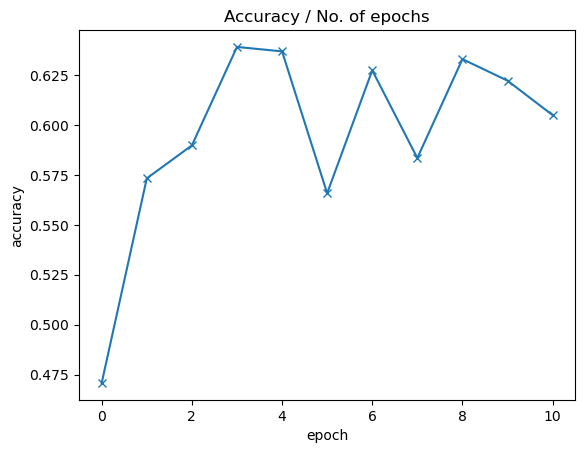

In [100]:
plot_accuracies(history)

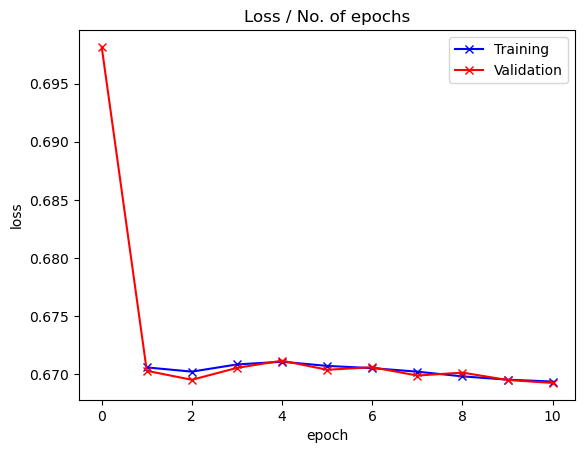

In [101]:
plot_losses(history)

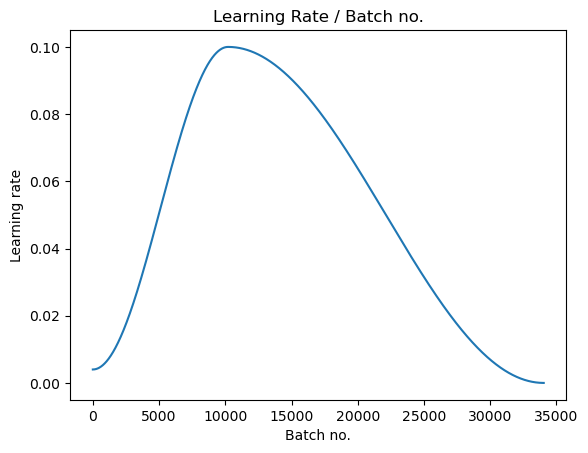

In [102]:
plot_lrs(history)

- Explications :<br>
Notre accuracy tourne autour de 0.60, ce qui, bien que meilleur que l'aléatoire de 0.50, reste bas. Ce constat s'explique cependant simplement. En effet, pour une bonne partie de la durée des replays étudiés, il est difficile de prévoir quel joueur va gagner. Par exemple, en début de partie, peu de choses se passent et les joueurs se contentent bien souvent de développer leur économie, ne laissant pas de joueur obtenir un quelconque avantage sur l'autre.<br>
Nous pouvons en revanche nous attendre à de bonne performances une fois que des batailles commencent à se dérouler, et de manière générale lorsque la partie se rapproche de la fin.

In [103]:
result = evaluate(model, val_loader)
result

{'val_loss': 0.6692659258842468, 'val_acc': 0.6049861311912537}

In [104]:
torch.save(model.state_dict(), 'starcraft2-logistic.pth')

In [105]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-9.4741e-05, -1.7600e-02, -9.2819e-03, -3.5742e-02, -5.3811e-01,
                        7.9974e-01, -3.8042e-01,  2.1418e-01, -2.9843e-01,  1.9367e-01,
                       -3.8524e-01,  2.5593e-01, -7.3365e-02,  2.6534e-02, -7.1745e-02,
                        2.8312e-02, -5.5342e-02,  1.6472e-02, -4.0649e-01,  4.5365e-01,
                       -1.5169e-01,  2.6338e-01, -1.3518e-01,  9.4890e-02,  6.5354e-02,
                       -7.3917e-02]])),
             ('linear.bias', tensor([-0.0534]))])

- Définition de la fonction de prédiction utilisant le réseau de neurones entraîné.

In [106]:
def predict(input_data, verbose = True):
    if verbose:
        for i in range(len(input_cols)):
            val = input_data[0][i].item()
            val = round(val * (data[input_cols[i]].max() - data[input_cols[i]].min()) + data[input_cols[i]].min(), 4)
            print(input_cols[i] + ":", val)
            
        print("")
    
    with torch.no_grad():
        pred = model(input_data[0]).item()
        
    print("Probabilité de victoire du joueur 1 : {:.4f}".format(1 - pred))

- Quelques prédictions.

In [107]:
predict(val_ds[42])

time: 264.0
race1: 1.0
race2: 1.0
map: 5.0
supplyUsed1: 52.0
supplyUsed2: 56.0
totalIncome1: 1835.0
totalIncome2: 1862.9999
mineralsIncome1: 1679.0
mineralsIncome2: 1707.0
vespeneIncome1: 156.0
vespeneIncome2: 156.0
totalResources1: 444.0
totalResources2: 493.0
minerals1: 170.0
minerals2: 350.0
vespene1: 274.0
vespene2: 143.0
activeWorkers1: 38.0
activeWorkers2: 36.0
army1: 650.0
army2: 850.0
technology1: 575.0
technology2: 450.0
lostResources1: 50.0
lostResources2: 100.0

Probabilité de victoire du joueur 1 : 0.5306


In [108]:
predict(val_ds[512])

time: 800.0
race1: 2.0
race2: 1.0
map: 35.0
supplyUsed1: 181.0
supplyUsed2: 106.5
totalIncome1: 2726.0001
totalIncome2: 2293.9999
mineralsIncome1: 1763.0001
mineralsIncome2: 1511.0001
vespeneIncome1: 963.0
vespeneIncome2: 783.0
totalResources1: 4363.9999
totalResources2: 266.0
minerals1: 2510.0
minerals2: 50.0
vespene1: 1854.0
vespene2: 216.0
activeWorkers1: 59.0
activeWorkers2: 45.0
army1: 9010.0
army2: 3874.9999
technology1: 4050.0
technology2: 3950.0
lostResources1: 2454.9999
lostResources2: 4600.0001

Probabilité de victoire du joueur 1 : 0.5940


## 5. Etude de cas pratiques

- Changeons de dataset pour utiliser notre fichier contenant 4 moments notable de 2 parties différentes (soit 8 rows).

In [109]:
dataPrime = pd.read_csv("archive/datasetPrime.csv")
dataPrime.head(len(dataPrime.index))

,time,race1,race2,map,supplyUsed1,supplyUsed2,totalIncome1,totalIncome2,mineralsIncome1,mineralsIncome2,...,vespene2,activeWorkers1,activeWorkers2,army1,army2,technology1,technology2,lostResources1,lostResources2,winner
0,100,2,0,0,20.0,20.0,1040,883,951,727,...,34,20,19,0,0,150,150,0,0,1
1,621,2,0,0,133.0,166.0,3655,3566,2827,2603,...,284,64,72,4325,5200,2750,3375,3300,2124,1
2,643,2,0,0,86.0,151.0,3498,3431,2715,2491,...,478,64,71,600,4450,3550,3575,7625,3799,1
3,721,2,0,0,79.0,170.0,3090,4109,2127,2967,...,762,65,73,175,5675,3150,4125,12450,5624,1
4,100,1,0,1,20.0,20.0,911,962,867,783,...,38,18,19,0,0,0,150,0,0,1
5,493,1,0,1,149.0,128.0,4574,2899,3723,2183,...,631,90,61,3650,4675,1700,2000,1043,0,1
6,507,1,0,1,110.0,121.0,4562,2966,3667,2183,...,294,90,61,1550,3325,2150,2000,3418,1300,1
7,779,1,0,1,94.0,167.0,2994,3252,2323,2491,...,378,72,58,750,5950,2025,3475,15328,10175,1


In [110]:
def predictor(n):
    data1 = list()
    
    for i in range(len(input_cols)):
        data1.append(dataPrime.iloc[n][i])
    
    data1 = [float(item) for item in data1]
    
    for col in range(len(input_cols)):
        data1[col] = (data1[col] - data[input_cols[col]].min()) / (data[input_cols[col]].max() - data[input_cols[col]].min())
    
    predict(torch.tensor([data1], dtype = torch.float32), verbose = False)

- Par la suite, le "joueur 1" désignera le joueur de couleur bleue.
- 1ère partie à 1 min 40 (début de partie) :

<img src="files/figures/TvP1.jpg" width="800px"/>

In [111]:
predictor(0)

Probabilité de victoire du joueur 1 : 0.5305


- 1ère partie à 10 min 21 (avant le combat) :

<img src="files/figures/TvP2.jpg" width="800px"/>

In [112]:
predictor(1)

Probabilité de victoire du joueur 1 : 0.5211


Image du déroulé du combat à titre indicatif.

<img src="files/figures/TvP3.jpg" width="800px"/>

- 1ère partie à 10 min 43 (après le combat) :

<img src="files/figures/TvP4.jpg" width="800px"/>

In [113]:
predictor(2)

Probabilité de victoire du joueur 1 : 0.5123


- 1ère partie à 12 min 01 (fin de partie) :

<img src="files/figures/TvP5.jpg" width="800px"/>

In [114]:
predictor(3)

Probabilité de victoire du joueur 1 : 0.4861


- 2ème partie à 1 min 40 (début de partie) :

<img src="files/figures/TvZ1.jpg" width="800px"/>

In [115]:
predictor(4)

Probabilité de victoire du joueur 1 : 0.5220


- 2ème partie à 8 min 13 (avant le combat) :

<img src="files/figures/TvZ2.jpg" width="800px"/>

In [116]:
predictor(5)

Probabilité de victoire du joueur 1 : 0.5961


Image du déroulé du combat à titre indicatif.

<img src="files/figures/TvZ3.jpg" width="800px"/>

- 2ème partie à 8 min 27 (après le combat) :

<img src="files/figures/TvZ4.jpg" width="800px"/>

In [117]:
predictor(6)

Probabilité de victoire du joueur 1 : 0.5907


- 2ème partie à 12 min 59 (fin de partie) :

<img src="files/figures/TvZ5.jpg" width="800px"/>

In [118]:
predictor(7)

Probabilité de victoire du joueur 1 : 0.5034
